### Imports

In [6]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle

# Parameters

In [7]:

# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
# symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.80)
validation_split = int(len(symbols[1]['EURUSD']) * 0.90)

In [8]:
# get the 2 weeks of the symbols[1]['EURUSD'] dataframe by first finding the max date
# then subtracting 14 days from that date
symbols[1]['EURUSD'].index = pd.to_datetime(symbols[1]['EURUSD'].index)
max_date = symbols[1]['EURUSD'].index.max()

In [9]:
# find the previous friday before max_date
# what is the day of the week of the max_date
max_day_of_week = max_date.dayofweek
# subtract the day of the week from the max_date to get the previous friday
max_friday = max_date - pd.DateOffset(days=max_day_of_week+2)
two_weeks = max_friday - pd.DateOffset(days=14)
one_week = max_friday - pd.DateOffset(days=7)

In [10]:
training_index_slice = symbols[1]['EURUSD'].loc[:one_week, :].index
validation_index_slice = symbols[1]['EURUSD'].loc[one_week:max_friday, :].index

In [11]:
validation_index_slice

DatetimeIndex(['2024-04-08 00:00:00+00:00', '2024-04-08 01:00:00+00:00',
               '2024-04-08 02:00:00+00:00', '2024-04-08 03:00:00+00:00',
               '2024-04-08 04:00:00+00:00', '2024-04-08 05:00:00+00:00',
               '2024-04-08 06:00:00+00:00', '2024-04-08 07:00:00+00:00',
               '2024-04-08 08:00:00+00:00', '2024-04-08 09:00:00+00:00',
               ...
               '2024-04-12 14:00:00+00:00', '2024-04-12 15:00:00+00:00',
               '2024-04-12 16:00:00+00:00', '2024-04-12 17:00:00+00:00',
               '2024-04-12 18:00:00+00:00', '2024-04-12 19:00:00+00:00',
               '2024-04-12 20:00:00+00:00', '2024-04-12 21:00:00+00:00',
               '2024-04-12 22:00:00+00:00', '2024-04-12 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=120, freq=None)

### Create Env

In [12]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [13]:
env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [29]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001

        # normalize the Volume with to have a mean of 1
        mean_value = env_orders['Volume'].mean()

        # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume_normalized'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward, env_orders

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [30]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    obs_tr, info_tr = env_tr.reset(seed=seed)
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    orders_over_validations_dfs = {}
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit, orders_df = my_profit_calculation(orders_made_in_episode, 0.001)
            orders_over_validations_dfs[f'{episode}'] = orders_df
            
        except:
            print('There were not any orders produced by the model')
            order_len = 0        

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    model.save(f'best_hyperparameters/models_4_27_24/model_{steps_str}.pkl')
    return reward_over_validations, orders_over_validations, orders_over_validations_dfs#, model_dict

## Objective Function

In [17]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 100 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except:
        print(f'''there was an error with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [18]:
best_hyperparameters_current_week = pd.read_excel('best_hyperparameter_search_results.xlsx')

0.01683527363887545

In [22]:
# # # check if it is working:
parameters = {
    # 'window_size': 10,
    # 'learning_timesteps': 25,
    'ent_coef': best_hyperparameters_current_week.loc[0,'ent_coef'],
    'gamma': best_hyperparameters_current_week.loc[0,'gamma'],
    'learning_rate': best_hyperparameters_current_week.loc[0,'learning_rate']
}
rewards_250, orders_250, orders_df_dict_250 = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, '250K',  
                                            parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 250_000)

--------------------------------------------------------------------------------
entropy: 0.01879460162445175, learning rate: 0.01683527363887545, gamma: 0.99
Episode: 0, Avg. Reward: -0.166, # of orders: 42.000, avg Profit: -224.783
Episode: 1, Avg. Reward: 0.745, # of orders: 41.000, avg Profit: 790.657
Episode: 2, Avg. Reward: 0.264, # of orders: 33.667, avg Profit: 270.732
Episode: 3, Avg. Reward: 0.072, # of orders: 29.250, avg Profit: 141.611
Episode: 4, Avg. Reward: 0.038, # of orders: 29.000, avg Profit: 96.550
Episode: 5, Avg. Reward: 0.283, # of orders: 31.500, avg Profit: 242.613
Episode: 6, Avg. Reward: 0.408, # of orders: 32.714, avg Profit: 394.583
Episode: 7, Avg. Reward: 0.308, # of orders: 31.250, avg Profit: 310.829
Episode: 8, Avg. Reward: 0.220, # of orders: 31.444, avg Profit: 198.966
Episode: 9, Avg. Reward: 0.233, # of orders: 31.700, avg Profit: 212.372


In [28]:
rewards_50, orders_50, orders_df_dict_50 = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, '250K',  
                                            parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 50_000)

--------------------------------------------------------------------------------
entropy: 0.01879460162445175, learning rate: 0.01683527363887545, gamma: 0.99
Episode: 0, Avg. Reward: 1.530, # of orders: 60.000, avg Profit: 2588.582
Episode: 1, Avg. Reward: 0.709, # of orders: 38.500, avg Profit: 1255.176
Episode: 2, Avg. Reward: 0.578, # of orders: 38.667, avg Profit: 1014.547
Episode: 3, Avg. Reward: 0.714, # of orders: 48.250, avg Profit: 1357.107
Episode: 4, Avg. Reward: 0.390, # of orders: 40.600, avg Profit: 991.873
Episode: 5, Avg. Reward: 0.219, # of orders: 36.500, avg Profit: 739.308
Episode: 6, Avg. Reward: 0.047, # of orders: 32.429, avg Profit: 553.190
Episode: 7, Avg. Reward: -0.027, # of orders: 30.750, avg Profit: 430.696
Episode: 8, Avg. Reward: 0.120, # of orders: 30.333, avg Profit: 549.282
Episode: 9, Avg. Reward: 0.156, # of orders: 32.800, avg Profit: 593.882


In [32]:
orders_df_dict['0'].Profit.sum()

2588.5820506547198

In [69]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
obs_tr, info_tr = env_train.reset(seed=seed)
obs_test, info_test = env_validation.reset(seed=seed)

total_reward = 0
done_test = False
reward_over_tests = {}
for training in ['', '250K_']:
    rewards = []
    for episode in range(500):
        obs_test, info_test = env_validation.reset(seed=seed)
        model_ppo = PPO.load(f'best_hyperparameters/models_4_27_24/model_{training}0.pkl', env_train)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit, orders_df = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except:
            print('There were not any orders produced by the model')
            order_len = 0
    reward_over_tests[f'{training}_1'] = rewards


In [ ]:
timesteps_test_df = pd.DataFrame(reward_over_tests, columns=['_1', '250K__1'])
timesteps_test_df = timesteps_test_df.rename(columns={'_1': '50K', '250K__1': '250K'})
timesteps_test_df

,50K,250K
0,0.107907,-0.821472


In [ ]:
# transform the dataframe to be a long dataframe where the columns 50K and 250K are in a column called timesteps and the values are in a second column called values
timesteps_test_df_long = pd.melt(timesteps_test_df, var_name='timesteps', value_name='values')
timesteps_test_df_long


,timesteps,values
0,50K,0.107907
1,250K,-0.821472


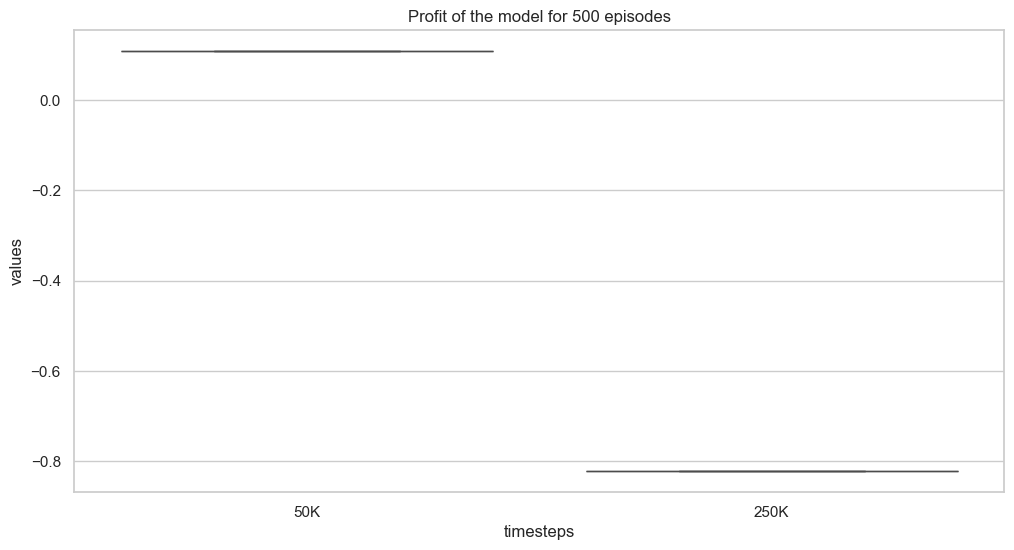

In [ ]:

# plot the timesteps_test_df results with the index on the x axis and the values for the columns as the y axis and the column names as the color of the dots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 
sns.boxplot(x='timesteps', y='values', data=timesteps_test_df_long)
plt.title('Profit of the model for 500 episodes')
plt.show()
